### Libraries

In [38]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, DepthwiseConv2D, GlobalAveragePooling2D, Reshape, Activation, Multiply, Input, Add
from keras.applications import EfficientNetB7
from keras import regularizers
from keras.optimizers import Adam
import matplotlib.pyplot as plt

### Settings

In [2]:
### Paths ###

# IP102 path
ip_102_path = "../../../Data/MSiA 432/03_hw/IP102-Dataset/"

# FairFace path
fair_face_path = "../../../Data/MSiA 432/03_hw/FairFace/"

# Question 1

In word document attatched with this submission

# Question 2

In [3]:
### Get image paths ###

columns = ["img_path", "target"]

train_df = pd.read_csv(ip_102_path + "train.txt", header=None, sep=" ", names=columns)
val_df = pd.read_csv(ip_102_path + "val.txt", header=None, sep=" ", names=columns)
test_df = pd.read_csv(ip_102_path + "test.txt", header=None, sep=" ", names=columns)

for df in [train_df, val_df, test_df]:
    df.target = df.target.astype(str)
    df['img_path'] = df['target'].astype(str) + '/' + df['img_path']

# Get # unique classes
num_classes = len(train_df.target.unique())

train_df.head()

,img_path,target
0,0/00002.jpg,0
1,0/00003.jpg,0
2,0/00005.jpg,0
3,0/00006.jpg,0
4,0/00008.jpg,0


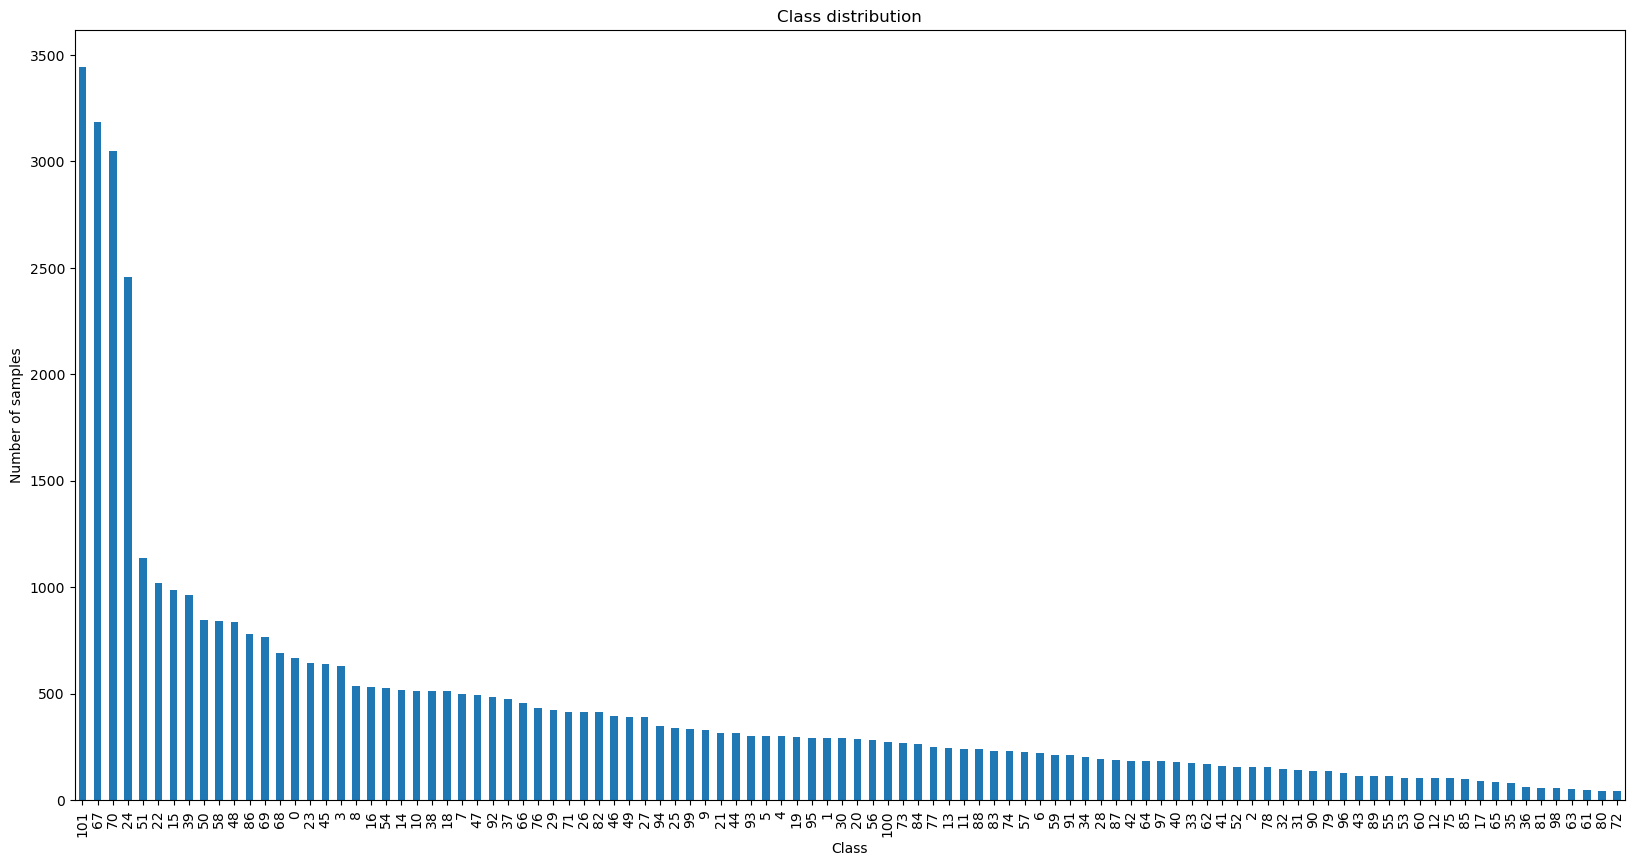

In [37]:
# Count the frequency of each class in the target column of the training set
class_counts = train_df['target'].value_counts()

# Plot class distribution
plt.figure(figsize=(20, 10))
class_counts.plot(kind='bar')
plt.title('Class distribution')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.xticks(rotation=90)
plt.show()

In [4]:
# Define ImageDataGenerator for training (with augmentation)
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest")

# Define ImageDataGenerator for validation and testing (without augmentation)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
# Set the batch size for the generators
batch_size = 32

# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(ip_102_path, "classification/train"),
    x_col="img_path",
    y_col="target",
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

# Validation data generator
val_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=os.path.join(ip_102_path, "classification/val"),
    x_col="img_path",
    y_col="target",
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

# Test data generator
test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=os.path.join(ip_102_path, "classification/test"),
    x_col="img_path",
    y_col="target",
    target_size=(100, 100),
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)

Found 45095 validated image filenames belonging to 102 classes.
Found 7508 validated image filenames belonging to 102 classes.
Found 22619 validated image filenames belonging to 102 classes.


### Model Settings

In [44]:
# Training paramaters
input_shape = (100, 100, 3)
optimizer = "adam"
loss = "categorical_crossentropy"
metrics = ["accuracy"]
epochs = 1
regs = (0.00001, 0.00001)

# Compute settings
gpus = (0,)

In [45]:
def set_gpus(*gpu_indices):
    # Get list of GPUs
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print("Num GPUs Available: ", len(gpus))

    if gpus:
        visible_gpus = [gpus[i] for i in gpu_indices]
        try:
            # Only use specified GPUs and ignore the others
            tf.config.experimental.set_visible_devices(visible_gpus, 'GPU')
            for gpu in visible_gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("Using GPUs: ", [gpu.name for gpu in visible_gpus])
        except RuntimeError as e:
            print(e)
    return visible_gpus

# Call the function with the indices of the GPUs you want to use
visible_gpus = set_gpus(*gpus)  # Use the second, third, fourth, and fifth GPU

# Extract names of the GPUs being used
gpu_names = ['/device:GPU:' + gpu.name.split(':')[-1] for gpu in visible_gpus]
print(gpu_names)

Num GPUs Available:  1
Using GPUs:  ['/physical_device:GPU:0']
['/device:GPU:0']


### Model Architecture Summary:

The CNN model is a Sequential model with the following layers:

- Two convolutional layers with 32 filters of size 3x3, using ReLU activation.
- Max pooling layer with pool size 2x2.
- Dropout layer with dropout rate 0.25.
- Two convolutional layers with 64 filters of size 3x3, using ReLU activation.
- Max pooling layer with pool size 2x2.
- Dropout layer with dropout rate 0.25.
- Flatten layer to reshape the tensor for the fully connected layers.
- Fully connected (Dense) layer with 512 nodes, using ReLU activation.
- Dropout layer with dropout rate 0.5.
- Output Dense layer with a number of nodes equal to the number of classes, using Softmax activation for multiclass classification.

### Hyperparameters and Reasoning:

- Optimizer: Adam is used because it's an effective optimizer that adjusts the learning rate adaptively for each weight.
- Loss function: Categorical Cross-Entropy is used because it's suitable for multi-class classification problems.
- Metrics: Accuracy is used to assess model performance.
- Number of filters and filter size in Conv2D: These are common choices, starting with a smaller number (32) and then doubling it (to 64). The size of (3,3) is often used in practice.
- Pool size in MaxPooling2D: (2,2) is a common choice to downscale the input.
- Dropout rates: These rates (0.25, 0.5) are typical to prevent overfitting, with a higher rate for the fully connected layer.
- Number of nodes in the first Dense layer: 512 is chosen for capacity, it should be adjusted based on the complexity of the problem.
- Activation functions: ReLU is used for the hidden layers because it helps with the vanishing gradient problem, and Softmax is used in the output layer for multiclass classification.

### Number of Parameters in Each Layer:

1. **First Conv2D layer**:
    - Number of filters: 32
    - Each filter size: 3x3
    - Input depth (channels): 3 (assuming RGB images)
    - Parameters per filter: 3 * 3 * 3 = 27 (weights) + 1 (bias)
    - Total parameters: 32 * (27 + 1) = 896

</br>

2. **Second Conv2D layer**:
    - Number of filters: 32
    - Each filter size: 3x3
    - Input depth (channels): 32 (output from previous layer)
    - Parameters per filter: 3 * 3 * 32 = 288 (weights) + 1 (bias)
    - Total parameters: 32 * (288 + 1) = 9248

</br>

3. **MaxPooling2D and Dropout layers** don't have trainable parameters.

</br>

4. **Third Conv2D layer**:
    - Number of filters: 64
    - Each filter size: 3x3
    - Input depth (channels): 32 (output from previous Conv2D layer)
    - Parameters per filter: 3 * 3 * 32 = 288 (weights) + 1 (bias)
    - Total parameters: 64 * (288 + 1) = 18496

</br>

5. **Fourth Conv2D layer**:
    - Number of filters: 64
    - Each filter size: 3x3
    - Input depth (channels): 64 (output from previous layer)
    - Parameters per filter: 3 * 3 * 64 = 576 (weights) + 1 (bias)
    - Total parameters: 64 * (576 + 1) = 36928

</br>

6. **Flatten layer**: The output of the previous layer is flattened. This layer doesn't introduce any new parameters.

</br>

7. **First Dense (fully-connected) layer**:
    - The input size will depend on the dimensions of the image after all the pooling operations and the number of filters in the last Conv2D layer. If this dimension is 'd', then:
        - Number of weights = d * 512
        - Number of biases = 512
        - Total parameters = (d * 512) + 512

</br>

8. **Second Dense (fully-connected) layer**:
    - This is the output layer of the network. The input to this layer is the output of the previous Dense layer, which has 512 neurons.
        - Number of weights = 512 * num_classes
        - Number of biases = num_classes
        - Total parameters = (512 * num_classes) + num_classes

In [48]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=gpu_names)

def create_model(input_shape, num_classes, regs):

    model = Sequential([

        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1_l2(l1=regs[0], l2=regs[1])),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), padding='same', activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax'),

    ])


    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)  # Suitable for classification

    return model

# Open the strategy scope
with strategy.scope():
    model = create_model(input_shape, num_classes, regs)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [47]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size
)

  71/1409 [>.............................] - ETA: 3:13 - loss: 4.2589 - accuracy: 0.0725

KeyboardInterrupt: 

In [ ]:
# Plotting the Training and Validation Loss Over Epochs
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Transfer Learning

In [18]:
def apply_transfer_learning(base_model, input_shape, num_classes, optimizer, loss, metrics):
    base_model.trainable = False  # Freeze layers

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())  # Flatten the output of the base model
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [19]:
efficientnet_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
efficientnet_tl_model = apply_transfer_learning(efficientnet_model, input_shape, num_classes, optimizer, loss, metrics)

258076736/258076736 [==============================] - 23s 0us/step


In [20]:
# Train EfficientNetB0 transfer learning model
history_efficientnet = efficientnet_tl_model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size
)

Epoch 1/10
1409/1409 [==============================] - 270s 177ms/step - loss: 55.1148 - accuracy: 0.0282 - val_loss: 45.1014 - val_accuracy: 0.0708
Epoch 2/10
 602/1409 [===========>..................] - ETA: 2:05 - loss: 50.7349 - accuracy: 0.0298

KeyboardInterrupt: 

# Question 3

# Question 4